# San Francisco Crime Classification

San Franscisco is the cultural, commercail and financial center of Northern California. It's city with almost 900,000 residents (2019). San Francisco has the highest salaries, disposable income and median home prices in the world. San Francisco was infamous for housing some of the world's most notorious criminals on island of Alcatraz. Today, the city is known more for its tech scene, than its criminal past. But, with rising wealth inequality housing shortgaes there is no scarcity of crime in San Francisco.

We would like to predict the category of crime occured in specific location based on coordinates and time.  We will explore a data set of nearly 12 years of crime reports and we will create a model that predicts the category of crime. 

## Data

This dataset contains incidents derived from SFPD Crime Incident Reporting system. The data ranges from 1/1/2003 to 5/13/2015. The training set and test set rotate every week, meaning week 1,3,5,7... belong to test set, week 2,4,6,8 belong to training set. 

**Data fields**

- Dates - timestamp of the crime incident
- Category - category of the crime incident (only in train.csv). This is the target variable you are going to predict.
- Descript - detailed description of the crime incident (only in train.csv)
- DayOfWeek - the day of the week
- PdDistrict - name of the Police Department District
- Resolution - how the crime incident was resolved (only in train.csv)
- Address - the approximate street address of the crime incident 
- X - Longitude
- Y - Latitude

### Importing libraries

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import copy
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import folium
import statsmodels.api as sm
import scikit_posthocs as sps
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

### Importing datasets

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

### Train dataset

In [3]:
train_df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [4]:
train_df.shape

(878049, 9)

Training datest contains 878,049 samples and nine features

In [5]:
train_df.describe()

,X,Y
count,878049.000000,878049.000000
mean,-122.422616,37.771020
std,0.030354,0.456893
min,-122.513642,37.707879
25%,-122.432952,37.752427
50%,-122.416420,37.775421
75%,-122.406959,37.784369
max,-120.500000,90.000000


Max. Y = 90, it can be some outlier.  Y = 90, point is located at the top of world map, it's outside San Francisco

In [6]:
train_df[train_df['Y'] >40.0]

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
660485,2005-12-30 17:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,TENDERLOIN,NONE,5THSTNORTH ST / OFARRELL ST,-120.5,90.0
660711,2005-12-30 00:34:00,ASSAULT,INFLICT INJURY ON COHABITEE,Friday,BAYVIEW,"ARREST, BOOKED",JAMESLICKFREEWAY HY / SILVER AV,-120.5,90.0
660712,2005-12-30 00:34:00,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Friday,BAYVIEW,"ARREST, BOOKED",JAMESLICKFREEWAY HY / SILVER AV,-120.5,90.0
661106,2005-12-29 00:07:00,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Thursday,TENDERLOIN,PSYCHOPATHIC CASE,5THSTNORTH ST / EDDY ST,-120.5,90.0
666430,2005-11-30 11:25:00,OTHER OFFENSES,TRAFFIC VIOLATION,Wednesday,TENDERLOIN,"ARREST, CITED",5THSTNORTH ST / ELLIS ST,-120.5,90.0
...,...,...,...,...,...,...,...,...,...
844995,2003-06-11 08:49:00,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Wednesday,INGLESIDE,"ARREST, CITED",JAMES LICK FREEWAY HY / CESAR CHAVEZ ST,-120.5,90.0
845842,2003-06-09 09:25:00,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Monday,INGLESIDE,"ARREST, CITED",JAMES LICK FREEWAY HY / CESAR CHAVEZ ST,-120.5,90.0
852880,2003-05-02 01:00:00,SEX OFFENSES FORCIBLE,"FORCIBLE RAPE, BODILY FORCE",Friday,SOUTHERN,COMPLAINANT REFUSES TO PROSECUTE,3RD ST / JAMES LICK FREEWAY HY,-120.5,90.0
857248,2003-04-14 16:30:00,ROBBERY,"ROBBERY ON THE STREET, STRONGARM",Monday,BAYVIEW,COMPLAINANT REFUSES TO PROSECUTE,GILMAN AV / FITCH ST,-120.5,90.0


There are only 67 samples with Y= 90. It's little compared to whole dataset, we will replace these samples by the average coordiantes of the district they belong.

In [7]:
train_df.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)
test_df.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

for district in train_df['PdDistrict'].unique():
    train_df.loc[train_df['PdDistrict'] == district, ['X', 'Y']] = imp_mean.fit_transform(
        train_df.loc[train_df['PdDistrict'] == district, ['X', 'Y']])
    test_df.loc[test_df['PdDistrict'] == district, ['X', 'Y']] = imp_mean.transform(
        test_df.loc[test_df['PdDistrict'] == district, ['X', 'Y']])

In [8]:
train_df.describe(include=['O'])

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address
count,878049,878049,878049,878049,878049,878049,878049
unique,389257,39,879,7,10,17,23228
top,2011-01-01 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,SOUTHERN,NONE,800 Block of BRYANT ST
freq,185,174900,60022,133734,157182,526790,26533


In [9]:
print('\033[1m'+"There all days of week: "+'\033[0m', train_df["DayOfWeek"].unique())

There all days of week:  ['Wednesday' 'Tuesday' 'Monday' 'Sunday' 'Saturday' 'Friday' 'Thursday']


In [10]:
print('\033[1m'+"There are 10 districts: "+'\033[0m', train_df["PdDistrict"].unique())

There are 10 districts:  ['NORTHERN' 'PARK' 'INGLESIDE' 'BAYVIEW' 'RICHMOND' 'CENTRAL' 'TARAVAL'
 'TENDERLOIN' 'MISSION' 'SOUTHERN']


In [11]:
print('\033[1m'+"There are 39 different categories of crime: "+'\033[0m',train_df["Category"].unique())

There are 39 different categories of crime:  ['WARRANTS' 'OTHER OFFENSES' 'LARCENY/THEFT' 'VEHICLE THEFT' 'VANDALISM'
 'NON-CRIMINAL' 'ROBBERY' 'ASSAULT' 'WEAPON LAWS' 'BURGLARY'
 'SUSPICIOUS OCC' 'DRUNKENNESS' 'FORGERY/COUNTERFEITING' 'DRUG/NARCOTIC'
 'STOLEN PROPERTY' 'SECONDARY CODES' 'TRESPASS' 'MISSING PERSON' 'FRAUD'
 'KIDNAPPING' 'RUNAWAY' 'DRIVING UNDER THE INFLUENCE'
 'SEX OFFENSES FORCIBLE' 'PROSTITUTION' 'DISORDERLY CONDUCT' 'ARSON'
 'FAMILY OFFENSES' 'LIQUOR LAWS' 'BRIBERY' 'EMBEZZLEMENT' 'SUICIDE'
 'LOITERING' 'SEX OFFENSES NON FORCIBLE' 'EXTORTION' 'GAMBLING'
 'BAD CHECKS' 'TREA' 'RECOVERED VEHICLE' 'PORNOGRAPHY/OBSCENE MAT']


 There are multiple categorical values. It's multi class classification problem

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null object
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB



We don't have any null values in our train dataset

In [13]:
train_df.duplicated().sum()

2323

There are 2323 duplicated samples in train dataset. Let's drop them.

In [14]:
train_df.drop_duplicates(inplace=True)

### Test dataset

In [15]:
test_df.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


In [16]:
test_df.shape

(884262, 7)


Test dataset doesn't have Category, Descript and Resolution columns

In [17]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884262 entries, 0 to 884261
Data columns (total 7 columns):
Id            884262 non-null int64
Dates         884262 non-null object
DayOfWeek     884262 non-null object
PdDistrict    884262 non-null object
Address       884262 non-null object
X             884262 non-null float64
Y             884262 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 47.2+ MB



We don't have any null values in our test dataset

In [18]:
test_df.describe()

,Id,X,Y
count,884262.000000,884262.000000,884262.000000
mean,442130.500000,-122.422858,37.766987
std,255264.596206,0.025345,0.024179
min,0.000000,-122.513642,37.707879
25%,221065.250000,-122.433069,37.752374
50%,442130.500000,-122.416517,37.775421
75%,663195.750000,-122.406959,37.784353
max,884261.000000,-122.364751,37.820621


It's the same case as with train dataset.

In [19]:
test_df.duplicated().sum()

0

None duplicates in test dataset.

## Exploratory Data Analysis (EDA)

#### Category

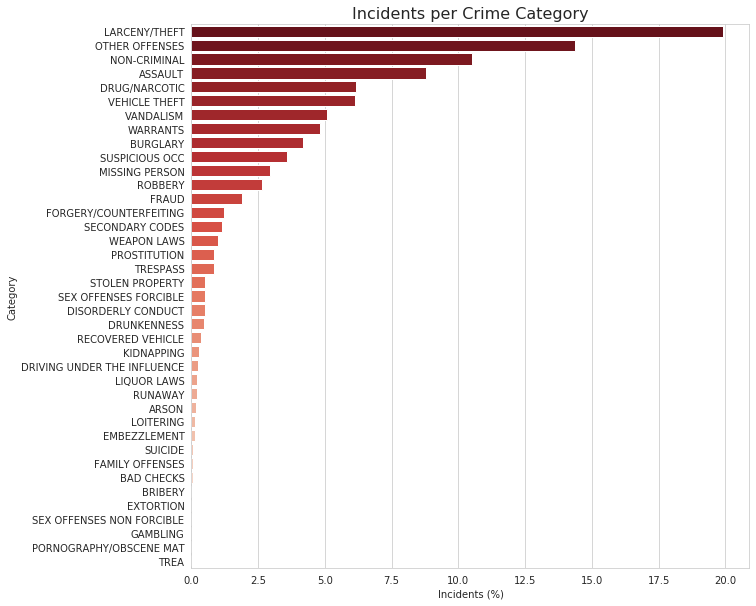

In [20]:
df_category = train_df.groupby(['Category'])['Dates'].count().sort_values(ascending=False)
plt.figure(figsize=(10, 10))
with sns.axes_style("whitegrid"):
    ax = sns.barplot(
        (df_category.values / df_category.values.sum()) * 100,
        df_category.index,
        orient='h',
        palette="Reds_r")

plt.title('Incidents per Crime Category', fontdict={'fontsize': 16})
plt.xlabel('Incidents (%)')

plt.show()

There are 39 categories of crimes. LARCENY/THEFT is most common, it's about 20% of all crimes. OTHER OFFENSES is untypical category, because it isn't known what really had happened. NON-CRIMINAL is about 10,5% of all crimes and ASSAULT is ~9%. 

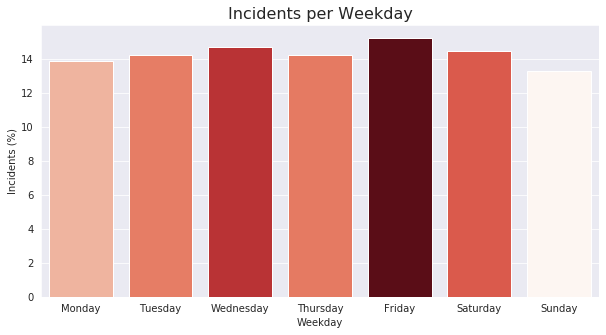

In [21]:
df_dayOfWeek = train_df.groupby(['DayOfWeek'])['Dates'].count()
df_dayOfWeek = df_dayOfWeek.reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
    'Sunday'
])
plt.figure(figsize=(10, 5))
with sns.axes_style("darkgrid"):
    ax = sns.barplot(
        df_dayOfWeek.index, (df_dayOfWeek.values / df_dayOfWeek.values.sum()) * 100,
        orient='v',
        palette=cm.ScalarMappable(cmap='Reds').to_rgba(df_dayOfWeek.values))

plt.title('Incidents per Weekday', fontdict={'fontsize': 16})
plt.xlabel('Weekday')
plt.ylabel('Incidents (%)')

plt.show()

We do not expect this variable to play a significant role in the prediction.

### Which District is the most dangerous

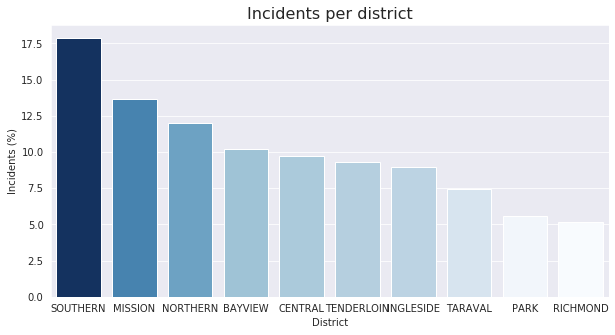

In [22]:
df_district = train_df.groupby(['PdDistrict'])['Dates'].count().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
with sns.axes_style("darkgrid"):
    ax = sns.barplot(
        df_district.index, (df_district.values / df_district.values.sum()) * 100,
        orient='v',
        palette=cm.ScalarMappable(cmap='Blues').to_rgba(df_district.values))

plt.title('Incidents per district', fontdict={'fontsize': 16})
plt.xlabel('District')
plt.ylabel('Incidents (%)')

plt.show()

SOUTHERN is the most dangerous police district. There were about 17.5 % incidents.   

Let's visualize it!

In [23]:
crime_district_count = pd.DataFrame(train_df.groupby(['PdDistrict'])['Dates'].count())
crime_district_count.reset_index(inplace=True)

In [24]:
latitude = 37.77
longitude = -122.42
sf_districts = f'data/sfpddistricts.geojson'

sf_map = folium.Map(
       location=[latitude,longitude],
       zoom_start=12)

sf_map.choropleth(
        geo_data=sf_districts,
        data=crime_district_count,
        columns=['PdDistrict','Dates'],
        key_on='feature.properties.DISTRICT',
        fill_color='YlOrRd',
        fill_opacity='0.7',
        line_opacity='0.2',
        legend_name='Crime Rate in San Francisco, by District')

sf_map

### Multiple crimes or group crime?

As we can see above, crimes 0 and 1 occured at the same time in the same location. Group crime or multiple crimes?

1     551833
2      96936
3      33855
4       4195
5       1355
6        434
7        159
8         69
9         38
10        13
11         9
12         4
13         1
dtype: int64

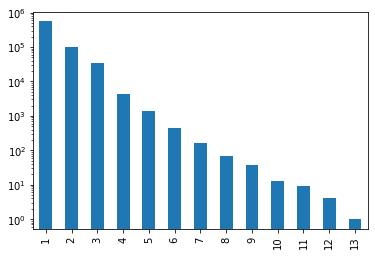

In [25]:
df_multiple_crimes = train_df.groupby(['Dates','X','Y']).size()
df_multiple_crimes_test = test_df.groupby(['Dates','X','Y']).size()
df_multiple_crimes.value_counts().plot('bar', logy=True)
df_multiple_crimes.value_counts()

As we can see it occurs not so rarely. There are about 300,000 multiply or group crimes.

In [26]:
other = pd.DataFrame(df_multiple_crimes)
other = other.reset_index()
multiple_crimes_df = train_df.merge(other, how='right')

In [27]:
multiple_crimes_df[multiple_crimes_df[0]==13]

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,0
20289,2015-02-04 23:21:00,WEAPON LAWS,TAMPERING WITH MARKS ON FIREARM,Wednesday,MISSION,"ARREST, BOOKED",FOLSOM ST / 22ND ST,-122.414389,37.7557,13
20290,2015-02-04 23:21:00,DRUG/NARCOTIC,POSSESSION OF MARIJUANA,Wednesday,MISSION,"ARREST, BOOKED",FOLSOM ST / 22ND ST,-122.414389,37.7557,13
20291,2015-02-04 23:21:00,WEAPON LAWS,"FIREARM, LOADED, IN VEHICLE, POSSESSION OR USE",Wednesday,MISSION,"ARREST, BOOKED",FOLSOM ST / 22ND ST,-122.414389,37.7557,13
20292,2015-02-04 23:21:00,WEAPON LAWS,"AMMUNITION, POSS. BY PROHIBITED PERSON",Wednesday,MISSION,"ARREST, BOOKED",FOLSOM ST / 22ND ST,-122.414389,37.7557,13
20293,2015-02-04 23:21:00,WEAPON LAWS,FIREARM POSSESSION IN SCHOOL ZONE,Wednesday,MISSION,"ARREST, BOOKED",FOLSOM ST / 22ND ST,-122.414389,37.7557,13
20294,2015-02-04 23:21:00,WEAPON LAWS,VIOLATION OF RESTRICTIONS ON A FIREARM TRANSFER,Wednesday,MISSION,"ARREST, BOOKED",FOLSOM ST / 22ND ST,-122.414389,37.7557,13
20295,2015-02-04 23:21:00,WEAPON LAWS,POSS OF LOADED FIREARM,Wednesday,MISSION,"ARREST, BOOKED",FOLSOM ST / 22ND ST,-122.414389,37.7557,13
20296,2015-02-04 23:21:00,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Wednesday,MISSION,"ARREST, BOOKED",FOLSOM ST / 22ND ST,-122.414389,37.7557,13
20297,2015-02-04 23:21:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,MISSION,"ARREST, BOOKED",FOLSOM ST / 22ND ST,-122.414389,37.7557,13
20298,2015-02-04 23:21:00,OTHER OFFENSES,RESISTING ARREST,Wednesday,MISSION,"ARREST, BOOKED",FOLSOM ST / 22ND ST,-122.414389,37.7557,13


13 crimes at the same time in the same place ? Let's see bigger group of multiple crimes.

In [28]:
multiple_crimes_df[multiple_crimes_df[0]==12]

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,0
185897,2012-11-17 18:34:00,DRUG/NARCOTIC,POSSESSION OF NARCOTICS PARAPHERNALIA,Saturday,RICHMOND,"ARREST, BOOKED",700 Block of ARGUELLO BL,-122.458612,37.776719,12
185898,2012-11-17 18:34:00,WEAPON LAWS,"FIREARM, LOADED, IN VEHICLE, POSSESSION OR USE",Saturday,RICHMOND,"ARREST, BOOKED",700 Block of ARGUELLO BL,-122.458612,37.776719,12
185899,2012-11-17 18:34:00,WEAPON LAWS,"FIREARM, ARMED WHILE POSSESSING CONTROLLED SUB...",Saturday,RICHMOND,"ARREST, BOOKED",700 Block of ARGUELLO BL,-122.458612,37.776719,12
185900,2012-11-17 18:34:00,DRUG/NARCOTIC,TRANSPORTATION OF MARIJUANA,Saturday,RICHMOND,"ARREST, BOOKED",700 Block of ARGUELLO BL,-122.458612,37.776719,12
185901,2012-11-17 18:34:00,OTHER OFFENSES,SPEEDING,Saturday,RICHMOND,"ARREST, BOOKED",700 Block of ARGUELLO BL,-122.458612,37.776719,12
185902,2012-11-17 18:34:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Saturday,RICHMOND,"ARREST, BOOKED",700 Block of ARGUELLO BL,-122.458612,37.776719,12
185903,2012-11-17 18:34:00,WEAPON LAWS,POSS OF LOADED FIREARM,Saturday,RICHMOND,"ARREST, BOOKED",700 Block of ARGUELLO BL,-122.458612,37.776719,12
185904,2012-11-17 18:34:00,WEAPON LAWS,POSS OF FIREARM BY CONVICTED FELON/ADDICT/ALIEN,Saturday,RICHMOND,"ARREST, BOOKED",700 Block of ARGUELLO BL,-122.458612,37.776719,12
185905,2012-11-17 18:34:00,DRUG/NARCOTIC,POSSESSION OF MARIJUANA,Saturday,RICHMOND,"ARREST, BOOKED",700 Block of ARGUELLO BL,-122.458612,37.776719,12
185906,2012-11-17 18:34:00,SUSPICIOUS OCC,INVESTIGATIVE DETENTION,Saturday,RICHMOND,"ARREST, BOOKED",700 Block of ARGUELLO BL,-122.458612,37.776719,12


Crimes comitted at **1200 Block of BAY SHORE BL** seems to be connected. It looks as is more than one person is involved in the crime. One person could be the driver and other his partner. Multiple offenses have been committed within one crime.

Crime commited at **REVERE AV / HAWES ST** looks similar, but seems to be committed by one person who took part in a car accident and had a gun. 

As we can see we probably have different cases:
- group crimes (2 or more person in 1 crime)
- multiple offenses commited by 1 person within 1 crime

There is no pattern to distinguish it, data could have extra feature contain such information.

## Data Preprocessing

- 2323 duplicate values and 67 rows with wrong latitues were removed earlier

In [29]:
train_df['Dates'] = pd.to_datetime(train_df['Dates'])
test_df['Dates'] = pd.to_datetime(test_df['Dates'])

### Extract part of day from *Dates* column

- 02:00-06:00 is **Dawn**
- 06:00-10:00 is **Morning**
- 10:00-14:00 is **Noon**
- 14:00-18:00 is **After noon**
- 18:00-22:00 is **Evening**
- 22:00-02:00 is **Night**

#### Define function which tells which part of the day is it

In [47]:
part_Of_Day_dic = {}
for i in range(2,23,4):
    part_Of_Day_dic["hour_"+str(i)] = pd.to_datetime(str(i)+':00:00').time()

def get_part_of_day(time):
    return (
        "Dawn" if part_Of_Day_dic.get('hour_2') <= time < part_Of_Day_dic.get('hour_6')
        else
        "Morning" if part_Of_Day_dic.get('hour_6') <= time < part_Of_Day_dic.get('hour_10')
        else
        "Noon" if part_Of_Day_dic.get('hour_10') <= time < part_Of_Day_dic.get('hour_14')
        else
        "After Noon" if part_Of_Day_dic.get('hour_14') <= time < part_Of_Day_dic.get('hour_18')
        else
        "Evening" if part_Of_Day_dic.get('hour_18') <= time < part_Of_Day_dic.get('hour_22')
        else 
        "Night"
    )

In [31]:
train_df['PartOfDay'] = train_df['Dates'].dt.time.apply(get_part_of_day)
test_df['PartOfDay'] = test_df['Dates'].dt.time.apply(get_part_of_day)

In [32]:
train_df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,PartOfDay
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,Night
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,Night
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,Night
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,Night
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,Night


### Extracting another features

- Year, Month,Day,Hour and Minute from 'Dates' field
- if crime has taken place on a building block or not

In [33]:
def extract_feature(dataFrame):
    dataFrame['Year'] = dataFrame['Dates'].dt.year
    dataFrame['Month'] = dataFrame['Dates'].dt.month
    dataFrame['Day'] = dataFrame['Dates'].dt.day
    dataFrame['Hour'] = dataFrame['Dates'].dt.hour
    dataFrame['Minute'] = dataFrame['Dates'].dt.minute
    dataFrame['Block'] = dataFrame['Address'].str.contains('block', case=False)
    
    dataFrame.drop(columns=['Dates','Address'], inplace=True)
    return dataFrame

In [34]:
train_df = extract_feature(train_df)
train_df.drop(columns=['Descript','Resolution'], inplace=True)
test_df = extract_feature(test_df)

In [35]:
train_df.head()

,Category,DayOfWeek,PdDistrict,X,Y,PartOfDay,Year,Month,Day,Hour,Minute,Block
0,WARRANTS,Wednesday,NORTHERN,-122.425892,37.774599,Night,2015,5,13,23,53,False
1,OTHER OFFENSES,Wednesday,NORTHERN,-122.425892,37.774599,Night,2015,5,13,23,53,False
2,OTHER OFFENSES,Wednesday,NORTHERN,-122.424363,37.800414,Night,2015,5,13,23,33,False
3,LARCENY/THEFT,Wednesday,NORTHERN,-122.426995,37.800873,Night,2015,5,13,23,30,True
4,LARCENY/THEFT,Wednesday,PARK,-122.438738,37.771541,Night,2015,5,13,23,30,True


### Data analysis based on extracted features

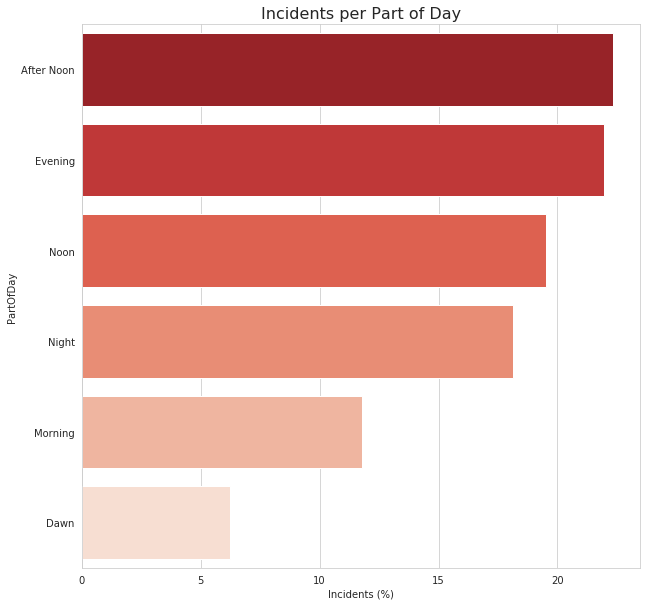

In [36]:
df_partOfDay = train_df.groupby(['PartOfDay'])['X'].count().sort_values(ascending=False)
# df_partOfDay.plot(kind='barh',figsize=(15,7))
plt.figure(figsize=(10, 10))
with sns.axes_style("whitegrid"):
    ax = sns.barplot(
        (df_partOfDay.values / df_partOfDay.values.sum()) * 100,
        df_partOfDay.index,
        orient='h',
        palette="Reds_r")

plt.title('Incidents per Part of Day', fontdict={'fontsize': 16})
plt.xlabel('Incidents (%)')

plt.show()

More than 45% incidents happened between 14:00-22:00 (After Noon - Evening). The fewest incidents were in the Morning and Dawn, because in this time, people usually are in their houses.

In [37]:
train_df.head()

,Category,DayOfWeek,PdDistrict,X,Y,PartOfDay,Year,Month,Day,Hour,Minute,Block
0,WARRANTS,Wednesday,NORTHERN,-122.425892,37.774599,Night,2015,5,13,23,53,False
1,OTHER OFFENSES,Wednesday,NORTHERN,-122.425892,37.774599,Night,2015,5,13,23,53,False
2,OTHER OFFENSES,Wednesday,NORTHERN,-122.424363,37.800414,Night,2015,5,13,23,33,False
3,LARCENY/THEFT,Wednesday,NORTHERN,-122.426995,37.800873,Night,2015,5,13,23,30,True
4,LARCENY/THEFT,Wednesday,PARK,-122.438738,37.771541,Night,2015,5,13,23,30,True


### How did number of crimes look each year

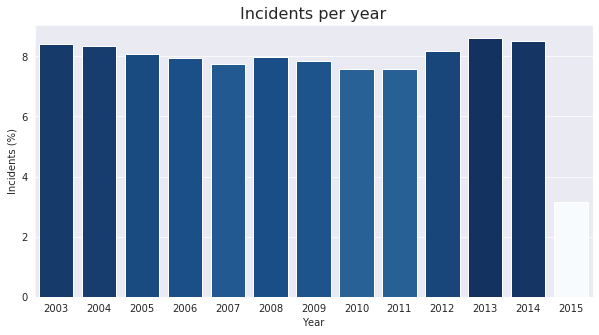

In [38]:
df_year = train_df.groupby('Year')['X'].count()
plt.figure(figsize=(10, 5))
with sns.axes_style("darkgrid"):
    ax = sns.barplot(
        df_year.index, (df_year.values / df_year.values.sum()) * 100,
        orient='v',
        palette=cm.ScalarMappable(cmap='Blues').to_rgba(df_year.values))

plt.title('Incidents per year', fontdict={'fontsize': 16})
plt.xlabel('Year')
plt.ylabel('Incidents (%)')

plt.show()

Each year number of crimes was similar. 2015 is different, because of data ranges 1/1/2013 to 5/13/2015



### Feature selecting

- Minute feature seems to be useless because in each minute was commited all categories of crimes
- Day feature - the same case as Minute feature
- Month feature can be useful because e.g. in the winter can be less crimes than in the summer
- Year feature it is hard to decide becuase in specific year some categories of crimes could have been less or more committed
- other features seems to be useful

Let's drop useless columns.

In [39]:
train_df.drop(columns=['Day','Minute'], inplace=True)
test_df.drop(columns=['Day','Minute'], inplace=True)

### Feature scaling

We ended up with 9 features. We will use One-Hot encoder to change string features to numerical.

In [40]:
train_df.head()

,Category,DayOfWeek,PdDistrict,X,Y,PartOfDay,Year,Month,Hour,Block
0,WARRANTS,Wednesday,NORTHERN,-122.425892,37.774599,Night,2015,5,23,False
1,OTHER OFFENSES,Wednesday,NORTHERN,-122.425892,37.774599,Night,2015,5,23,False
2,OTHER OFFENSES,Wednesday,NORTHERN,-122.424363,37.800414,Night,2015,5,23,False
3,LARCENY/THEFT,Wednesday,NORTHERN,-122.426995,37.800873,Night,2015,5,23,True
4,LARCENY/THEFT,Wednesday,PARK,-122.438738,37.771541,Night,2015,5,23,True


In [41]:
train_df_encoded = pd.get_dummies(train_df, columns=["PdDistrict", "DayOfWeek", "PartOfDay"])
test_df_encoded = pd.get_dummies(test_df, columns=["PdDistrict", "DayOfWeek", "PartOfDay"])

train_df_encoded["X_Hour"] = np.cos((train_df_encoded["Hour"]/24)*360)
train_df_encoded["Y_Hour"] = np.sin((train_df_encoded["Hour"]/24)*360)

test_df_encoded["X_Hour"] = np.cos((test_df_encoded["Hour"]/24)*360)
test_df_encoded["Y_Hour"] = np.sin((test_df_encoded["Hour"]/24)*360)

train_df_encoded["Block"] = train_df_encoded["Block"].astype(int)
test_df_encoded["Block"] = test_df_encoded["Block"].astype(int)

le  = LabelEncoder()
y = le.fit_transform(train_df_encoded.pop('Category'))

train_df_encoded.drop(columns=['Hour'], inplace=True)
test_df_encoded.drop(columns=['Hour'], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(train_df_encoded, y, test_size=0.3, stratify=y)

In [42]:
train_df_encoded.head()

,X,Y,Year,Month,Block,PdDistrict_BAYVIEW,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,PdDistrict_MISSION,PdDistrict_NORTHERN,...,DayOfWeek_Tuesday,DayOfWeek_Wednesday,PartOfDay_After Noon,PartOfDay_Dawn,PartOfDay_Evening,PartOfDay_Morning,PartOfDay_Night,PartOfDay_Noon,X_Hour,Y_Hour
0,-122.425892,37.774599,2015,5,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0.839088,-0.543996
1,-122.425892,37.774599,2015,5,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0.839088,-0.543996
2,-122.424363,37.800414,2015,5,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0.839088,-0.543996
3,-122.426995,37.800873,2015,5,1,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0.839088,-0.543996
4,-122.438738,37.771541,2015,5,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0.839088,-0.543996


In [43]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Modeling

### PCA - Principal Component Analysis

In [44]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)

evr = np.round(pca.explained_variance_ratio_,2)
print('Coefficients of explained variance for individual components:\n%s' % evr)

Coefficients of explained variance for individual components:
[0.07 0.06 0.05 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04
 0.04 0.04 0.04 0.04 0.04 0.04 0.03 0.03 0.03 0.03 0.03 0.   0.   0.
 0.   0.  ]


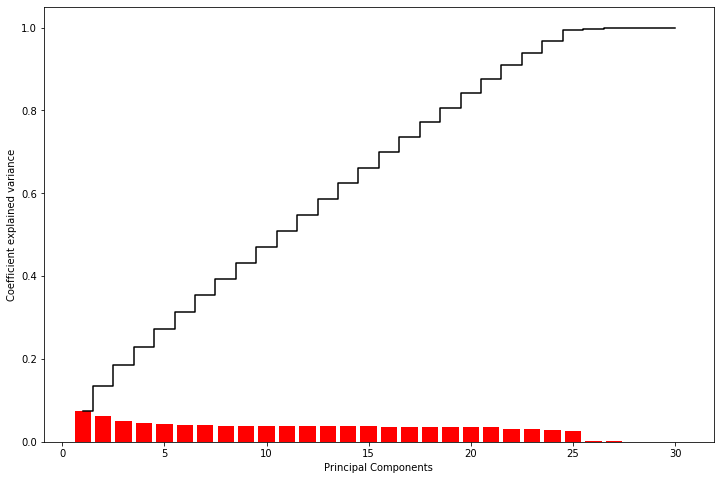

In [45]:
plt.figure(figsize = (12,8))
plt.bar(range(1, 31), pca.explained_variance_ratio_, align = 'center', color = 'red')
plt.step(range(1, 31), np.cumsum(pca.explained_variance_ratio_), where = 'mid', color = 'black')
plt.ylabel('Coefficient explained variance')
plt.xlabel('Principal Components')

plt.show()

As we expected each component has similar explained variance. PCA tried to put maximum possible information in the first component, then maximum remaining information in the second and so on. As we can see, we can't reduce dimensionality without losing much information, because each Component represents similar amount of information.

Let's test 3 different algorithms:
- Logistic Regression (LR)  [linear]
- K-Nearest Neighbors (KNN)  [nonlinear]
- Random Forest Classifier (RFC)  [nonlinear]



In [ ]:
models = []
models.append(('LR',LogisticRegression(),{'C':[0.01,0.1,1]}))
models.append(('KNN',KNeighborsClassifier(),{'n_neighbors':[2,3,4,5,6,7,8,9,10,15,20,30,40]}))
models.append(('RFC',RandomForestClassifier(),{'max_depth':[2,5,6,7,8,9,10,15,20,30,40],'n_estimators':[50,100,200]}))

column_names = ["Name", "TrainAccuracy", "TestAccuracy", "BestParameters"]
models_df = pd.DataFrame(columns = column_names)
for name,model,parameters in models:
    clf = GridSearchCV(model, parameters)
    clf.fit(X_train_std, y_train)
    models_df.loc[0 if pd.isnull(models_df.index.max()) else models_df.index.max() + 1] = [name,accuracy_score(y_train, clf.predict(X_train_std)), accuracy_score(y_test, clf.predict(X_test_std)), clf.best_params_]

Results were computed in PyCharm because of its reliability. 

#### Baseline:
- THE MOST COMMON CATEGORY OF CRIME - **19,9%**

![Results](results.PNG)

In [ ]:
test_std = sc.transform(test_df)
y_test_pred = clf.predict_proba(test_std)
sub=pd.read_csv('data/sampleSubmission.csv')
sub.shape
y_test_pred.shape
sub.iloc[:,1:] = y_test_pred.round(4)
sub.head()
sub.to_csv('submission.csv',index=False)

## Statistical analysis of Day of Week (to present understanding of issue)

In [96]:
array = train_df.groupby([train_df['Dates'].dt.date,train_df['DayOfWeek']])['X'].count().reset_index()
dayOfWeek_list = [
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday'
]
dayOfWeek_dic = {}
for day in dayOfWeek_list:
    dayOfWeek_dic[day] = array[array['DayOfWeek']==day]['X'].array

In [97]:
def testn(day,array,num,dataframe):
        
        l = np.array(array)
        alfa = 0.05
        m, s = sp.stats.norm.fit(l)
        norm_of_dist = False
        
        test = sm.stats.diagnostic.lilliefors(l, dist='norm', pvalmethod= 'table')
        
        if round(test[1],4) <= alfa/num:
            norm_of_dist = False
        else:
            norm_of_dist = True
        dataframe.loc[0 if pd.isnull(dataframe.index.max()) else dataframe.index.max() + 1] = [day,round(sp.stats.kurtosis(l),2), round(sp.stats.skew(l),2), norm_of_dist]

In [98]:
column_names = ["Day", "Kurtosis", "Slant", "NormalityOfDistribution"]
result_df = pd.DataFrame(columns = column_names)
for key, value in dayOfWeek_dic.items():
    testn(key,value,1,result_df)

In [99]:
result_df.head(7)

,Day,Kurtosis,Slant,NormalityOfDistribution
0,Monday,1.30,-0.05,True
1,Tuesday,2.08,-0.36,True
2,Wednesday,2.71,-0.38,True
3,Thursday,1.43,-0.42,True
4,Friday,1.71,-0.01,True
5,Saturday,2.94,0.69,False
6,Sunday,10.35,-0.41,False


In [100]:
dayOfWeek_dic_to_norm = copy.deepcopy(dayOfWeek_dic)
for key, value in dayOfWeek_dic_to_norm.items():
    dayOfWeek_dic_to_norm[key] = sp.stats.boxcox(value, lmbda=None, alpha=None)[0]

In [101]:
result_normalized_df = pd.DataFrame(columns = column_names)
for key, value in dayOfWeek_dic_to_norm.items():
    testn(key,value,1,result_normalized_df)
result_normalized_df.head(7)

,Day,Kurtosis,Slant,NormalityOfDistribution
0,Monday,1.20,0.06,True
1,Tuesday,1.12,0.09,True
2,Wednesday,1.15,0.11,True
3,Thursday,1.21,0.08,True
4,Friday,1.75,0.07,True
5,Saturday,2.01,0.00,True
6,Sunday,6.26,0.50,False


In [104]:
if round(sp.stats.levene(*dayOfWeek_dic.values(),center = 'median')[1],4) <= 0.05/2:
        print('Based on test performed \033[92mwe reject\033[0m hypothesis of homogeneity of variance in the studied groups.\n')
else:
        print('There is no reason to reject the hypothesis of homogeneity of variance in the studied groups.\n')

There is no reason to reject the hypothesis of homogeneity of variance in the studied groups.



Null hypothesis:
-  the population median of all of the groups are equal

Alternative hypothesis:
- at least two groups are different

In [106]:
if round(sp.stats.kruskal(*dayOfWeek_dic.values())[1],4) <= 0.05/2:
            print('Based on test performed \033[92mwe reject\033[0m hypothesis of equality of medians in the studied groups.\n')
else:
        print('There is no reason to reject the hypothesis of homogeneity of equality of medians in the studied groups.\n')

Based on test performed we reject hypothesis of equality of medians in the studied groups.



In [107]:
round(sps.posthoc_dunn([*dayOfWeek_dic.values()]),4)

,1,2,3,4,5,6,7
1,-1.0000,0.0033,0.0000,0.0002,0.0000,0.0000,0.0
2,0.0033,-1.0000,0.0000,0.4130,0.0000,0.1362,0.0
3,0.0000,0.0000,-1.0000,0.0011,0.0003,0.0097,0.0
4,0.0002,0.4130,0.0011,-1.0000,0.0000,0.5023,0.0
5,0.0000,0.0000,0.0003,0.0000,-1.0000,0.0000,0.0
6,0.0000,0.1362,0.0097,0.5023,0.0000,-1.0000,0.0
7,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-1.0


Based on statistic tests, we can see that:
- **Tuesday - Thursday - Saturday** satisfy null hypothesis

- other days are statistically different.

# Different approach to the problem

We will try predict future categories of crimes based on past crimes.

In [102]:
df_train = pd.read_csv('data/train.csv')

In [103]:
df_train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


###  Cleaning dataset as above

##### Replacing outliers by mean

In [104]:
df_train.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

for district in df_train['PdDistrict'].unique():
    df_train.loc[df_train['PdDistrict'] == district, ['X', 'Y']] = imp_mean.fit_transform(
        df_train.loc[df_train['PdDistrict'] == district, ['X', 'Y']])

##### Removing duplicates

In [105]:
df_train.drop_duplicates(inplace=True)

## Feature extracting

In [106]:
df_train['Dates'] = pd.to_datetime(df_train['Dates'])

In [107]:
def extract_feature_new(dataFrame):
    dataFrame['Year'] = dataFrame['Dates'].dt.year
    dataFrame['Month'] = dataFrame['Dates'].dt.month
    dataFrame['Day'] = dataFrame['Dates'].dt.day
    dataFrame['Hour'] = dataFrame['Dates'].dt.hour
    dataFrame['Minute'] = dataFrame['Dates'].dt.minute
    dataFrame['Block'] = dataFrame['Address'].str.contains('block', case=False)
    
    dataFrame.drop(columns=['Address', 'Descript', 'Resolution'], inplace=True)
    return dataFrame

In [108]:
df_train = extract_feature_new(df_train)

In [109]:
df_train['PartOfDay'] = df_train['Dates'].dt.time.apply(get_part_of_day)

In [110]:
df_train.head()

,Dates,Category,DayOfWeek,PdDistrict,X,Y,Year,Month,Day,Hour,Minute,Block,PartOfDay
0,2015-05-13 23:53:00,WARRANTS,Wednesday,NORTHERN,-122.425892,37.774599,2015,5,13,23,53,False,Night
1,2015-05-13 23:53:00,OTHER OFFENSES,Wednesday,NORTHERN,-122.425892,37.774599,2015,5,13,23,53,False,Night
2,2015-05-13 23:33:00,OTHER OFFENSES,Wednesday,NORTHERN,-122.424363,37.800414,2015,5,13,23,33,False,Night
3,2015-05-13 23:30:00,LARCENY/THEFT,Wednesday,NORTHERN,-122.426995,37.800873,2015,5,13,23,30,True,Night
4,2015-05-13 23:30:00,LARCENY/THEFT,Wednesday,PARK,-122.438738,37.771541,2015,5,13,23,30,True,Night


In [111]:
df_train.sort_values(by=['Dates'], inplace=True)

### Encoding

In [112]:
df_train.head()

,Dates,Category,DayOfWeek,PdDistrict,X,Y,Year,Month,Day,Hour,Minute,Block,PartOfDay
878048,2003-01-06 00:01:00,FORGERY/COUNTERFEITING,Monday,BAYVIEW,-122.394926,37.738212,2003,1,6,0,1,True,Night
878045,2003-01-06 00:01:00,LARCENY/THEFT,Monday,INGLESIDE,-122.447364,37.731948,2003,1,6,0,1,True,Night
878047,2003-01-06 00:01:00,VANDALISM,Monday,SOUTHERN,-122.390531,37.780607,2003,1,6,0,1,False,Night
878046,2003-01-06 00:01:00,LARCENY/THEFT,Monday,SOUTHERN,-122.403390,37.780266,2003,1,6,0,1,False,Night
878044,2003-01-06 00:15:00,ROBBERY,Monday,TARAVAL,-122.459033,37.714056,2003,1,6,0,15,False,Night


In [113]:
df_train['X_Y'] = df_train['X'].astype(str)+" "+df_train['Y'].astype(str)

In [114]:
df_train.drop(columns=['Day','Minute'], inplace=True)

In [115]:
df_train_encoded = df_train

In [117]:
df_train_encoded = pd.get_dummies(df_train_encoded, columns=["PdDistrict", "DayOfWeek", "PartOfDay"])

df_train_encoded["X_Hour"] = np.cos((df_train_encoded["Hour"]/24)*360)
df_train_encoded["Y_Hour"] = np.sin((df_train_encoded["Hour"]/24)*360)

df_train_encoded["Block"] = df_train_encoded["Block"].astype(int)

df_train_encoded.drop(columns=['Hour'], inplace=True)

le  = LabelEncoder()
df_train_encoded['Category'] = le.fit_transform(df_train_encoded['Category'])


### Lag Features
The past values are known as lags, so t-1 is lag 1, t-2 is lag 2, and so on.

In [119]:
df_array = []
for cords in df_train_encoded['X_Y'].unique():
    df_tmp = df_train_encoded[df_train_encoded['X_Y']==cords]
    for i in range(1,8):
        df_tmp["lag_"+str(i)] = df_tmp['Category'].shift(i)
    df_array.append(df_tmp)

In [120]:
df_train_encoded = pd.concat(df_array)

In [121]:
df_train_encoded.sort_values(by=['Dates'], inplace=True)

In [122]:
df_train_encoded.head()

,Dates,Category,X,Y,Year,Month,Block,X_Y,PdDistrict_BAYVIEW,PdDistrict_CENTRAL,...,PartOfDay_Noon,X_Hour,Y_Hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
878048,2003-01-06 00:01:00,12,-122.394926,37.738212,2003,1,1,-122.394925721424 37.738211541051996,1,0,...,0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
878045,2003-01-06 00:01:00,16,-122.447364,37.731948,2003,1,1,-122.447363507104 37.7319475636101,0,0,...,0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
878047,2003-01-06 00:01:00,35,-122.390531,37.780607,2003,1,0,-122.39053140418699 37.78060707982429,0,0,...,0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
878046,2003-01-06 00:01:00,16,-122.403390,37.780266,2003,1,0,-122.403390364804 37.780265577696,0,0,...,0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
878044,2003-01-06 00:15:00,25,-122.459033,37.714056,2003,1,0,-122.459033097784 37.7140562686562,0,0,...,0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [138]:
df_train_encoded_copy = df_train_encoded

In [157]:
df_train_encoded_copy.drop(columns=['Dates','X_Y'], inplace=True)

#### Impact of features on Category type

It's used 5% sample of total dataset, because of computation complexity

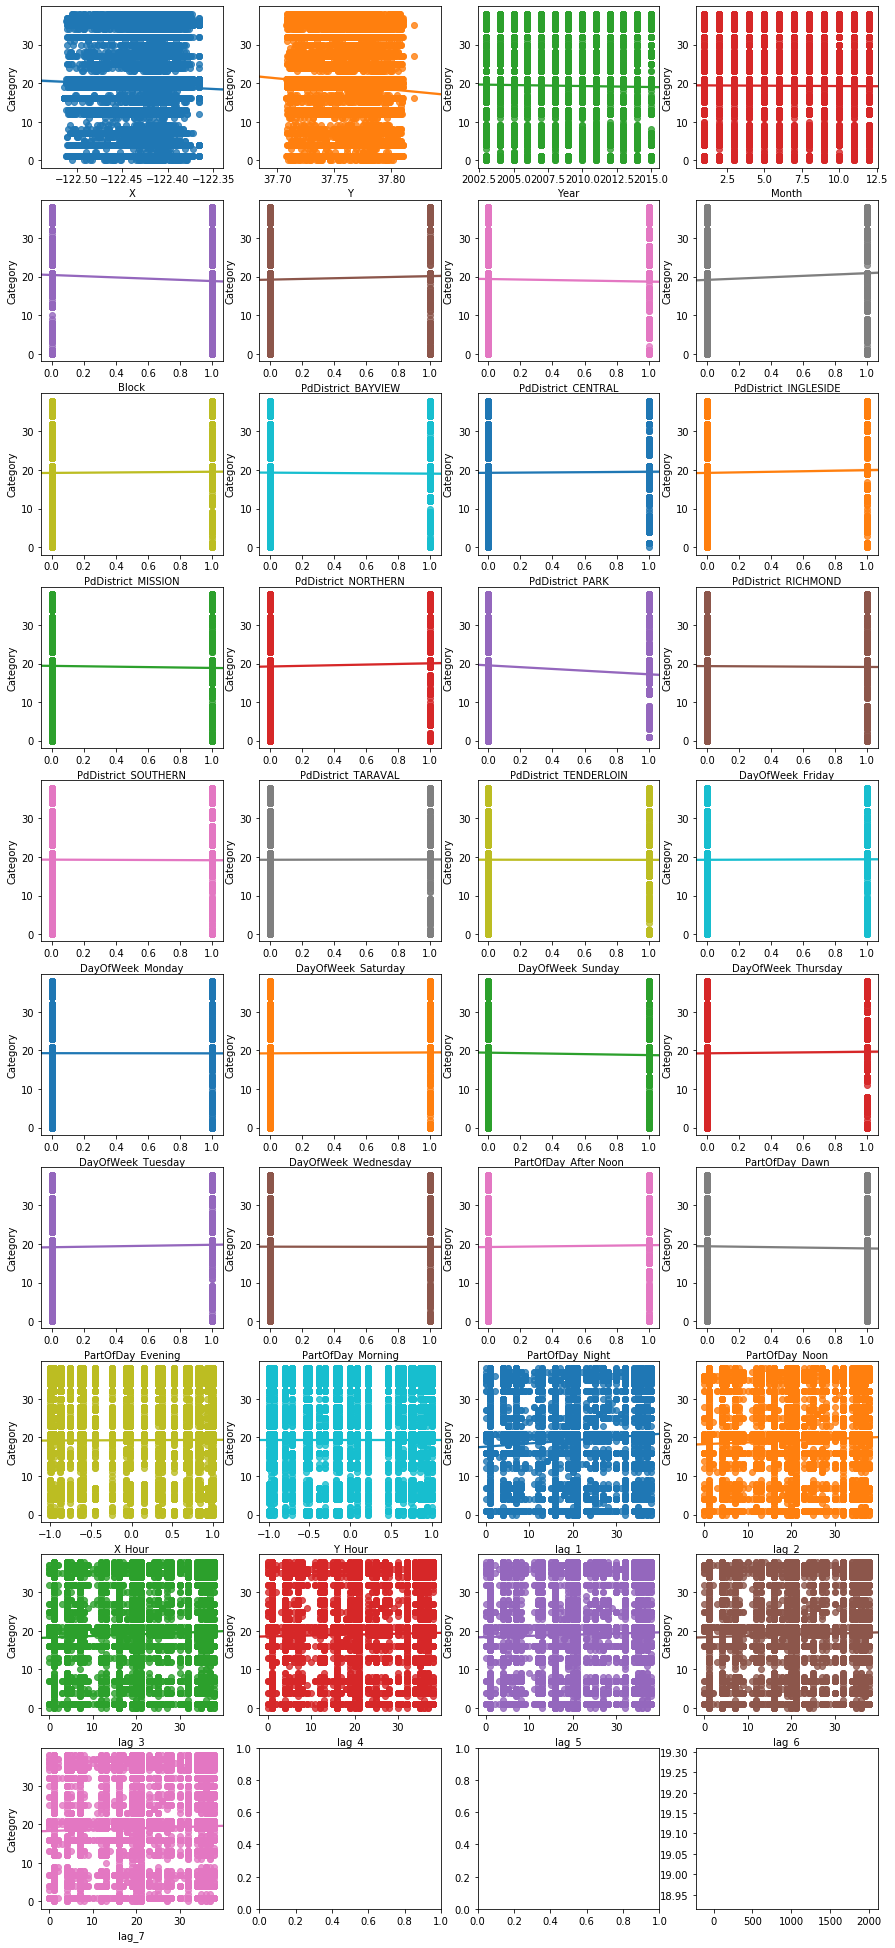

In [182]:
cols = list(df_train_encoded_copy)
cols = cols[1:len(cols)]
fig, axs = plt.subplots(10,4,figsize=(15,35))
k = 0
for i in range(0,10):
    for j in range(0,4):
        sns.regplot(x =str(cols[k]), y = 'Category', data = df_train_encoded_copy.sample(frac = 0.05, random_state=1),ax=axs[i][j]) 
        k = k+1
        if (k > len(cols)-1):
            break

In [185]:
y = df_train_encoded_copy.pop('Category')
sc1 = StandardScaler()
sc1.fit(df_train_encoded_copy)
df_train_encoded_copy_std = sc1.transform(df_train_encoded_copy)


We divide dataset into train and test sets in proportion 1:4. All crimes commited in train set are older than in test set. 

In [187]:
Xtrain = df_train_encoded_copy_std[0:(len(df_train_encoded_copy_std)-int(0.2*len(df_train_encoded_copy_std)))]
Xtest = df_train_encoded_copy_std[(len(df_train_encoded_copy_std)-int(0.2*len(df_train_encoded_copy_std))):len(df_train_encoded_copy_std)]
ytrain = y[0:(len(y)-int(0.2*len(y)))]
ytest = y[(len(y)-int(0.2*len(y))):len(y)]

## Modeling
We will use best models from first approach to this problem due to computation complexity